In [1]:
# %load test_windef.py
"""
Created on Fri Oct  4 14:33:21 2019

@author: Theo
"""

import matplotlib.pyplot as plt

import numpy as np
import openpiv.windef as windef
from test_process import create_pair, shift_u, shift_v, threshold
from openpiv.pyprocess import get_coordinates, extended_search_area_piv, get_field_shape
from openpiv import validation, filters
import scipy.ndimage as scn
# from openpiv.windef import frame_interpolation

from scipy.interpolate import RectBivariateSpline

In [2]:
frame_a, frame_b = create_pair(image_size=256)

# this test are created only to test the displacement evaluation of the
# function the validation methods are not tested here ant therefore
# are disabled.

In [3]:
# circular cross correlation
def test_first_pass_circ():
    """ test of the first pass """
    x, y, u, v, s2n = windef.first_pass(
        frame_a,
        frame_b,
        window_size=64,
        overlap=32,
        iterations=1,
        correlation_method="circular",
        subpixel_method="gaussian",
        do_sig2noise=True,
        sig2noise_method="peak2peak",
        sig2noise_mask=2,
    )
    # print("\n", x, y, u, v, s2n)
    plt.quiver(x,y,u,v)
    
    assert np.mean(np.abs(u - shift_u)) < threshold
    assert np.mean(np.abs(v - shift_v)) < threshold

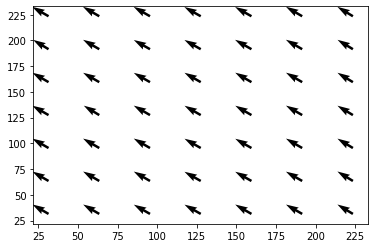

In [4]:
test_first_pass_circ()

In [5]:

def frame_interpolation(frame, x, y, u, v, interpolation_order=1):
    """This one is doing the image deformation also known as window deformation
    Therefore, the pixel values of the old image are interpolated on a new
    grid that is defined by the grid of the previous pass and the displacment
    evaluated by the previous pass
    """
    """
    The interpolation function dont like meshgrids as input. Hence, the the
    edges must be extracted to provide the sufficient input, also the y
    coordinates need to be inverted since the image origin is in the upper
    left corner and the y-axis goes downwards. The x-axis goes to the right.
    """
    frame = frame.astype(np.float32)
    y1 = y[:, 0]  # extract first coloumn from meshgrid
    # y1 = y1[::-1]  # flip
    x1 = x[0, :]  # extract first row from meshgrid
    side_x = np.arange(0, np.size(frame[0, :]), 1)  # extract the image grid
    side_y = np.arange(0, np.size(frame[:, 0]), 1)

    # interpolate the diplacement on the image grid
    ip = RectBivariateSpline(y1, x1, u)
    # the way how to use the interpolation functions differs
    ut = ip(side_y, side_x)
    # from matlab
    ip2 = RectBivariateSpline(y1, x1, v)
    vt = ip2(side_y, side_x)

    """This lines are interpolating the displacement from the interrogation window
    grid onto the image grid. The result is displacment meshgrid with the size
    of the image.
    """
    x, y = np.meshgrid(side_x, side_y)  # create a meshgrid
    frame_def = scn.map_coordinates(
        frame, ((y + vt, x + ut,)), order=interpolation_order, mode="nearest"
    )
    # deform the image by using the map coordinates function
    return frame_def

In [6]:
def multipass_img_deform(
    frame_a,
    frame_b,
    window_size,
    overlap,
    iterations,
    current_iteration,
    x_old,
    y_old,
    u_old,
    v_old,
    correlation_method="circular",
    subpixel_method="gaussian",
    do_sig2noise=False,
    sig2noise_method="peak2peak",
    sig2noise_mask=2,
    MinMaxU=(-100, 50),
    MinMaxV=(-50, 50),
    std_threshold=5,
    median_threshold=2,
    median_size=1,
    filter_method="localmean",
    max_filter_iteration=10,
    filter_kernel_size=2,
    interpolation_order=3,
):
    """
    Multi pass of the PIV evaluation.

    This function does the PIV evaluation of the second and other passes.
    It returns the coordinates of the interrogation window centres,
    the displacement u, v for each interrogation window as well as
    the mask which indicates
    wether the displacement vector was interpolated or not.


    Parameters
    ----------
    frame_a : 2d np.ndarray
        the first image

    frame_b : 2d np.ndarray
        the second image

    window_size : tuple of ints
         the size of the interrogation window

    overlap : tuple of ints
        the overlap of the interrogation window, e.g. window_size/2

    x_old : 2d np.ndarray
        the x coordinates of the vector field of the previous pass

    y_old : 2d np.ndarray
        the y coordinates of the vector field of the previous pass

    u_old : 2d np.ndarray
        the u displacement of the vector field of the previous pass

    v_old : 2d np.ndarray
        the v displacement of the vector field of the previous pass

    subpixel_method: string
        the method used for the subpixel interpolation.
        one of the following methods to estimate subpixel location of the peak:
        'centroid' [replaces default if correlation map is negative],
        'gaussian' [default if correlation map is positive],
        'parabolic'

    MinMaxU : two elements tuple
        sets the limits of the u displacment component
        Used for validation.

    MinMaxV : two elements tuple
        sets the limits of the v displacment component
        Used for validation.

    std_threshold : float
        sets the  threshold for the std validation

    median_threshold : float
        sets the threshold for the median validation

    filter_method : string
        the method used to replace the non-valid vectors
        Methods:
            'localmean',
            'disk',
            'distance',

    max_filter_iteration : int
        maximum of filter iterations to replace nans

    filter_kernel_size : int
        size of the kernel used for the filtering

    interpolation_order : int
        the order of the spline interpolation used for the image deformation

    Returns
    -------
    x : 2d np.array
        array containg the x coordinates of the interrogation window centres

    y : 2d np.array
        array containg the y coordinates of the interrogation window centres

    u : 2d np.array
        array containing the u displacement for every interrogation window

    u : 2d np.array
        array containing the u displacement for every interrogation window

    mask : 2d np.array
        array containg the mask values (bool) which contains information if
        the vector was filtered

    """

    x, y = get_coordinates(np.shape(frame_a), window_size, overlap)

    "calculate the y and y coordinates of the interrogation window centres"
    """The interpolation function dont like meshgrids as input. Hence, the
    edges must be extracted to provide the sufficient input. x_old and y_old
    are the coordinates of the old grid. x_int and y_int are the coordinates
    of the new grid"""
    
    import pdb
    # pdb.set_trace()
    
    print(f"Iteration {current_iteration}")
    

    y_old = y_old[:, 0]
    # y_old = y_old[::-1]
    x_old = x_old[0, :]
    
    print(x_old,y_old)
    
    
    y_int = y[:, 0]
    # y_int = y_int[::-1]
    x_int = x[0, :]
    
    print(x_int,y_int)

    # interpolating the displacements from the old grid onto the new grid
    # y befor x because of numpy works row major
    ip = RectBivariateSpline(y_old, x_old, u_old, kx=2, ky=2)
    u_pre = ip(y_int, x_int)

    ip2 = RectBivariateSpline(y_old, x_old, v_old, kx=2, ky=2)
    v_pre = ip2(y_int, x_int)

    # this one is doing the image deformation (see above)
    frame_b_deform = frame_interpolation(
        frame_b, x, y, u_pre, v_pre, interpolation_order=interpolation_order
    )

    if do_sig2noise is True and \
            current_iteration == iterations and \
            iterations != 1:
        sig2noise_method = sig2noise_method
    else:
        sig2noise_method = None

    u, v, s2n = extended_search_area_piv(
                                    frame_a, frame_b_deform,
                                    window_size=window_size,
                                    overlap=overlap,
                                    search_area_size=window_size,
                                    width=sig2noise_mask,
                                    subpixel_method=subpixel_method,
                                    sig2noise_method=sig2noise_method
                                    )

    shapes = np.array(get_field_shape(frame_a.shape, window_size, overlap))
    u = u.reshape(shapes)
    v = v.reshape(shapes)
    s2n = s2n.reshape(shapes)

    # adding the recent displacment on to the displacment of the previous pass
    u += u_pre
    v -= v_pre

    # validation using gloabl limits and local median
    u, v, mask_g = validation.global_val(u, v, MinMaxU, MinMaxV)
    u, v, mask_s = validation.global_std(u, v, std_threshold=std_threshold)
    u, v, mask_m = validation.local_median_val(
        u,
        v,
        u_threshold=median_threshold,
        v_threshold=median_threshold,
        size=median_size,
    )

    # adding masks to add the effect of alle the validations
    mask = mask_g + mask_m + mask_s

    # mask=np.zeros_like(u)
    # filter to replace the values that where marked by the validation
    if current_iteration != iterations:
        # filter to replace the values that where marked by the validation
        u, v = filters.replace_outliers(
            u,
            v,
            method=filter_method,
            max_iter=max_filter_iteration,
            kernel_size=filter_kernel_size,
        )

    return x, y, u, v, s2n, mask


In [7]:
def test_multi_pass_circ():
    """ test fot the multipass """
    window_size = (128, 64, 32)
    overlap = (64, 32, 16)
    iterations = 3

    x, y, u, v, s2n = windef.first_pass(
        frame_a,
        frame_b,
        window_size[0],
        overlap[0],
        iterations,
        correlation_method="circular",
        subpixel_method="gaussian",
        do_sig2noise=True,
        sig2noise_method="peak2peak",
        sig2noise_mask=2,
    )
    u_old = u.copy()
    v_old = v.copy()
    plt.figure()
    plt.quiver(x,y,u,v,color='r')
    
    for i in range(2, iterations + 1):
        x, y, u, v, s2n, mask = multipass_img_deform(
            frame_a,
            frame_b,
            window_size[i - 1],
            overlap[i - 1],
            iterations,
            i,
            x,
            y,
            u,
            v,
            correlation_method="circular",
            subpixel_method="gaussian",
            do_sig2noise=False,
            sig2noise_method="peak2peak",
            sig2noise_mask=2,
            MinMaxU=(-100, 50),
            MinMaxV=(-50, 50),
            std_threshold=1000000,
            median_threshold=200000,
            median_size=1,
            filter_method="localmean",
            max_filter_iteration=10,
            filter_kernel_size=2,
            interpolation_order=3,
        )
        plt.figure()
        plt.quiver(x,y,u,v,color='b')

    # print("\n", x, y, u, v, s2n)
    
    assert np.mean(np.abs(u - shift_u)) < threshold and np.any(u != u_old)
    assert np.mean(np.abs(v - shift_v)) < threshold and np.any(v != v_old)
    # the second condition is to check if the multipass is done.
    # It need's a little numerical inaccuracy.

Iteration 2
[ 63.5 127.5 191.5] [ 63.5 127.5 191.5]
[ 31.5  63.5  95.5 127.5 159.5 191.5 223.5] [ 31.5  63.5  95.5 127.5 159.5 191.5 223.5]
Iteration 3
[ 31.5  63.5  95.5 127.5 159.5 191.5 223.5] [ 31.5  63.5  95.5 127.5 159.5 191.5 223.5]
[ 15.5  31.5  47.5  63.5  79.5  95.5 111.5 127.5 143.5 159.5 175.5 191.5
 207.5 223.5 239.5] [ 15.5  31.5  47.5  63.5  79.5  95.5 111.5 127.5 143.5 159.5 175.5 191.5
 207.5 223.5 239.5]


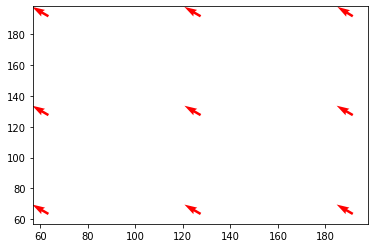

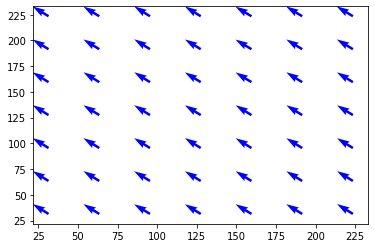

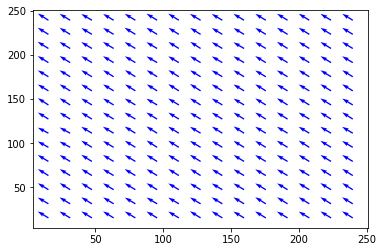

In [8]:
test_multi_pass_circ()

In [9]:
# linear cross correlation
def test_first_pass_lin():
    """ test of the first pass """
    x, y, u, v, s2n = windef.first_pass(
        frame_a,
        frame_b,
        window_size=64,
        overlap=32,
        iterations=1,
        correlation_method="linear",
        subpixel_method="gaussian",
        do_sig2noise=True,
        sig2noise_method="peak2peak",
        sig2noise_mask=2,
    )
    print("\n", x, y, u, v, s2n)
    plt.quiver(x,y,u,v)
    assert np.mean(np.abs(u - shift_u)) < threshold
    assert np.mean(np.abs(v - shift_v)) < threshold


def test_multi_pass_lin():
    """ test fot the multipass """
    window_size = (128, 64, 32)
    overlap = (64, 32, 16)
    iterations = 3

    x, y, u, v, s2n = windef.first_pass(
        frame_a,
        frame_b,
        window_size[0],
        overlap[0],
        iterations,
        correlation_method="linear",
        subpixel_method="gaussian",
        do_sig2noise=True,
        sig2noise_method="peak2peak",
        sig2noise_mask=2,
    )
    u_old = u.copy()
    v_old = v.copy()
    i = 1
    for i in range(2, iterations + 1):
        x, y, u, v, sn, m = windef.multipass_img_deform(
            frame_a,
            frame_b,
            window_size[i - 1],
            overlap[i - 1],
            iterations,
            i,
            x,
            y,
            u,
            v,
            correlation_method="linear",
            subpixel_method="gaussian",
            do_sig2noise=False,
            sig2noise_method="peak2peak",
            sig2noise_mask=2,
            MinMaxU=(-100, 50),
            MinMaxV=(-50, 50),
            std_threshold=1000000,
            median_threshold=200000,
            median_size=1,
            filter_method="localmean",
            max_filter_iteration=10,
            filter_kernel_size=2,
            interpolation_order=3,
        )

    print("\n", x, y, u, v, s2n)
    plt.quiver(x,y,u,v)
    assert np.max(np.abs(u - shift_u)) < threshold and np.any(u != u_old)
    assert np.max(np.abs(v - shift_v)) < threshold and np.any(v != v_old)

    # the second condition is to check if the multipass is done.
    # It need's a little numerical inaccuracy.


 [[ 31.5  63.5  95.5 127.5 159.5 191.5 223.5]
 [ 31.5  63.5  95.5 127.5 159.5 191.5 223.5]
 [ 31.5  63.5  95.5 127.5 159.5 191.5 223.5]
 [ 31.5  63.5  95.5 127.5 159.5 191.5 223.5]
 [ 31.5  63.5  95.5 127.5 159.5 191.5 223.5]
 [ 31.5  63.5  95.5 127.5 159.5 191.5 223.5]
 [ 31.5  63.5  95.5 127.5 159.5 191.5 223.5]] [[ 31.5  31.5  31.5  31.5  31.5  31.5  31.5]
 [ 63.5  63.5  63.5  63.5  63.5  63.5  63.5]
 [ 95.5  95.5  95.5  95.5  95.5  95.5  95.5]
 [127.5 127.5 127.5 127.5 127.5 127.5 127.5]
 [159.5 159.5 159.5 159.5 159.5 159.5 159.5]
 [191.5 191.5 191.5 191.5 191.5 191.5 191.5]
 [223.5 223.5 223.5 223.5 223.5 223.5 223.5]] [[-5.59733971 -5.60401925 -5.62817727 -5.6427127  -5.64489986 -5.62763702
  -5.39322712]
 [-5.59132438 -5.62065366 -5.64397511 -5.65617712 -5.6473005  -5.65244721
  -5.39741875]
 [-5.65078603 -5.62909744 -5.65301484 -5.63004381 -5.62672135 -5.64046321
  -5.37746429]
 [-5.64411599 -5.3790538  -5.65891313 -5.62925089 -5.62509552 -5.64207914
  -5.37134609]
 [-5.62260

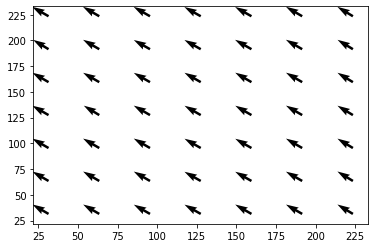

In [10]:
test_first_pass_lin()